## Regression problem: Calculate the distance to the object from the ocean surface

In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, cross_validation
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
import statsmodels.stats.api as ss
from statsmodels.compat import lzip
import seaborn as sns
%matplotlib inline

/home/user/dummy/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read file and preprocessing
file_reg = "Ex07_Sonar_Regreesion.csv"
sonar_data_reg = pd.read_csv(file_reg)
sonar_data_reg = sonar_data_reg.fillna(sonar_data_reg.pH.mean())

In [3]:
x_reg = sonar_data_reg.drop("Distance", axis=1)
y_reg = sonar_data_reg.Distance

## Scatter plots of each feature with the target to see relationship

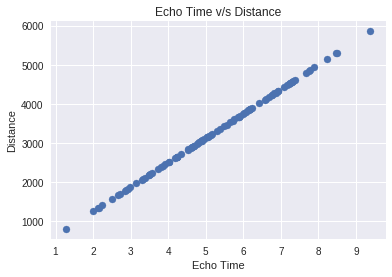

In [4]:
plt.scatter(sonar_data_reg.EchoTime, y_reg)
plt.xlabel("Echo Time")
plt.ylabel("Distance")
plt.title("Echo Time v/s Distance")
plt.show()

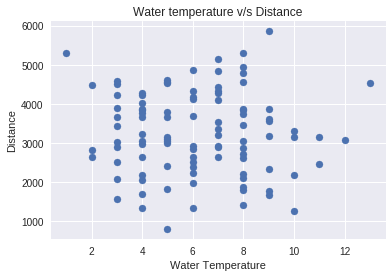

In [5]:
plt.scatter(sonar_data_reg.WaterTemp, y_reg)
plt.xlabel("Water Temperature")
plt.ylabel("Distance")
plt.title("Water temperature v/s Distance")
plt.show()

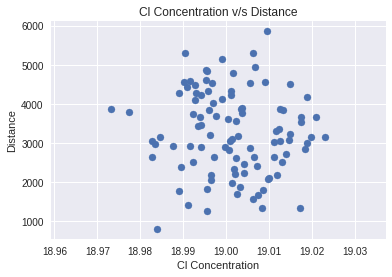

In [6]:
plt.scatter(sonar_data_reg.Clconcentration, y_reg)
plt.xlabel("Cl Concentration")
plt.ylabel("Distance")
plt.title("Cl Concentration v/s Distance")
plt.show()

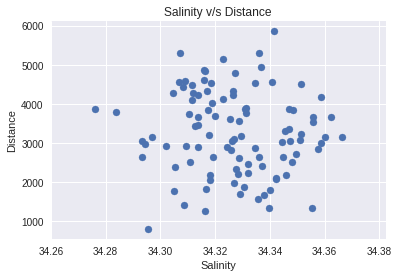

In [7]:
plt.scatter(sonar_data_reg.Salinity, y_reg)
plt.xlabel("Salinity")
plt.ylabel("Distance")
plt.title("Salinity v/s Distance")
plt.show()

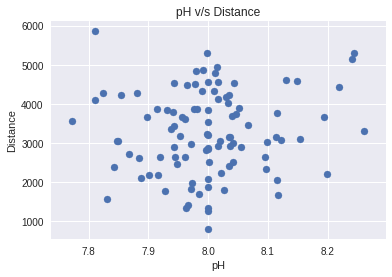

In [8]:
plt.scatter(sonar_data_reg.pH, y_reg)
plt.xlabel("pH")
plt.ylabel("Distance")
plt.title("pH v/s Distance")
plt.show()

## Basic Analysis by Correlation Matrix

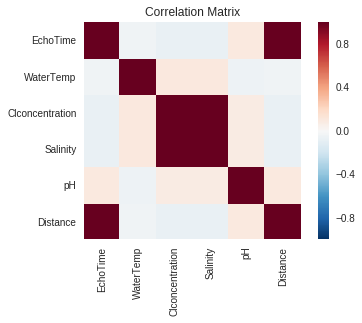

In [9]:
corr = sonar_data_reg.corr()
plt.figure()
sns.heatmap(corr, square=True)
plt.title("Correlation Matrix")
plt.show()

In [10]:
# Creating the test and train datasets
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x_reg, y_reg, test_size=0.33, random_state=5)

In [11]:
# Standardising the data
x_train_sc = (x_train-x_train.mean())/x_train.std()
y_train_sc = (y_train-y_train.mean())/y_train.std()
x_test_sc = (x_test-x_test.mean())/x_test.std()

## 1. Linear Regression Model

FINDING MODEL COEFFICIENTS

In [12]:
reg = linear_model.LinearRegression()
reg = reg.fit(x_train_sc, y_train_sc)
tr_coeffs = reg.coef_
tr_resi = reg.residues_
tr_intr = reg.intercept_
print("Coeffs: ", tr_coeffs)
print("Residuals: ", tr_resi)
print("Intercept: ", tr_intr)

Coeffs:  [  1.00000025e+00   1.49595374e-06  -1.57953550e+05   1.57953550e+05
  -8.48621998e-07]
Residuals:  4.97204435036e-09
Intercept:  3.77369525834e-07


/home/user/dummy/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


PREDICT THE MODEL

In [13]:
pred_test = reg.predict(x_test_sc)
pred_test = (pred_test*y_test.std())+y_test.mean()

PLOT PREDICTED AND ACTUAL DISTANCE

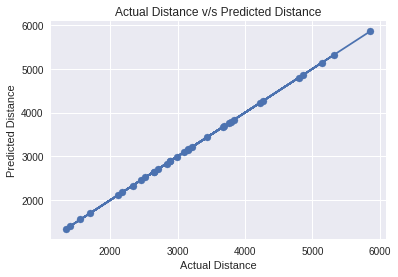

In [14]:
plt.scatter(y_test, pred_test)
plt.plot(y_test, y_test)
plt.xlabel("Actual Distance")
plt.ylabel("Predicted Distance")
plt.title("Actual Distance v/s Predicted Distance")
plt.show()

ERROR CALCULATION

In [15]:
error_abs = np.abs(pred_test-y_test)
error = pred_test-y_test

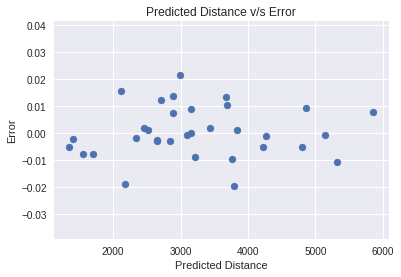

In [16]:
plt.scatter(pred_test, error)
plt.xlabel("Predicted Distance")
plt.ylabel("Error")
plt.title("Predicted Distance v/s Error")
plt.show()

MEAN OF ERROR (APPROXIMATELY ZERO)

In [17]:
error.mean()

0.00045985633195496945

MEAN SQUARE ERROR

In [18]:
# mean square error train data
train_mse1 = np.mean((error)**2)
# mean square error test data
test_mse1 = np.mean((error)**2)
print(train_mse1)
print(test_mse1)

8.76880335828e-05
8.76880335828e-05


HISTOGRAM

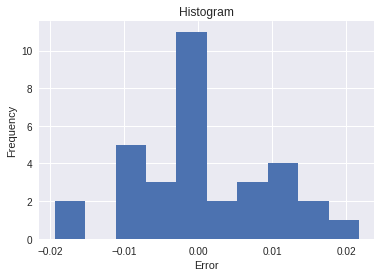

In [19]:
plt.hist(error)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

BOX PLOT

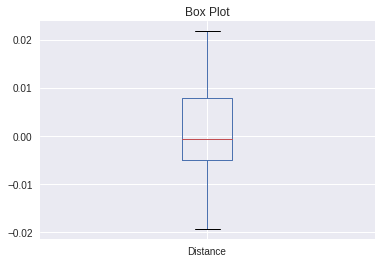

In [20]:
y = pd.DataFrame(error)
y.plot(kind='box')
plt.title("Box Plot")
plt.show()

## 2. Linear Regression Model : Ridge

In [21]:
alphas_r = np.linspace(0.0001,15,1000)*0.5

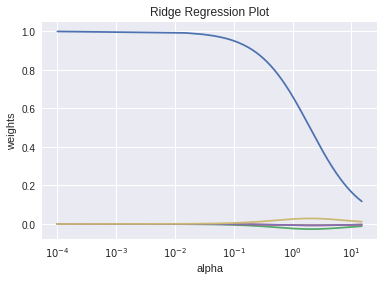

In [22]:
ridge = linear_model.Ridge(normalize=True)
coeffs = []
for a in alphas_r:
    ridge.set_params(alpha=a)
    ridge.fit(np.array(x_train_sc), np.array(y_train_sc))
    coeffs.append(ridge.coef_)
ax = plt.gca()
ax.plot(2*alphas_r, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title("Ridge Regression Plot")
plt.show()

In [23]:
ridgecv = linear_model.RidgeCV(alphas=alphas_r, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(np.array(x_train_sc), np.array(y_train_sc))
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(np.array(x_train_sc), np.array(y_train_sc))
pred = ridge.predict(x_test_sc)
mean_squared_error(y_test, (pred*y_test.std())+y_test.mean())

0.0033586397280627282

In [24]:
print(pd.Series(ridge.coef_, index=x_test_sc.columns))
print("Intercept: ", ridge.intercept_)
print("Aplha: ", ridge.alpha)

EchoTime           0.999949
WaterTemp         -0.000004
Clconcentration   -0.000002
Salinity          -0.000002
pH                 0.000005
dtype: float64
Intercept:  -1.62175082134e-16
Aplha:  5e-05


PREDICT THE MODEL

In [25]:
pred_ridge = ridge.predict(np.array(x_test_sc))
pred_ridge = (pred_ridge*y_test.std())+y_test.mean()

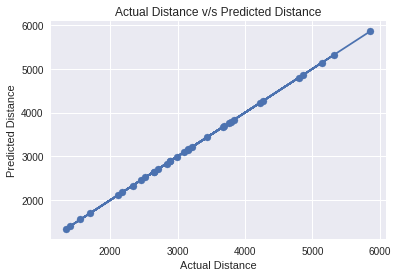

In [26]:
plt.scatter(y_test, pred_ridge)
plt.plot(y_test, y_test)
plt.xlabel("Actual Distance")
plt.ylabel("Predicted Distance")
plt.title("Actual Distance v/s Predicted Distance")
plt.show()

ERROR CALCULATION

In [27]:
errors_abs = np.abs(np.array(y_test) - pred_ridge)
errors = np.array(y_test).reshape(33,1) - pred_ridge.reshape(33,1)

In [28]:
errors.mean()

1.3573519412823247e-12

In [29]:
errors.var()

0.0033586397280627287

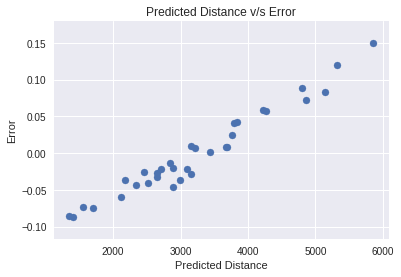

In [30]:
plt.scatter(np.array(y_test).reshape(33,1), errors)
plt.xlabel("Predicted Distance")
plt.ylabel("Error")
plt.title("Predicted Distance v/s Error")
plt.show()

HISTOGRAM OF ERRORS : RIDGE

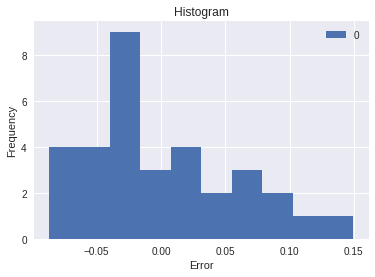

In [31]:
y = pd.DataFrame(errors)
y.plot(kind = 'hist')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

BOX PLOT

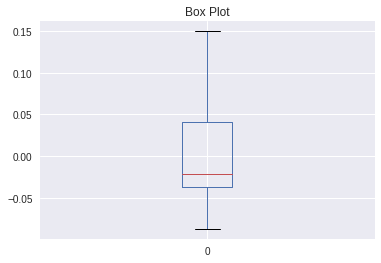

In [32]:
y.plot(kind = 'box')
plt.title("Box Plot")
plt.show()

## 3. Linear Regression Model : Lasso

In [33]:
alphas = np.linspace(0.0001,0.5,1000)*0.5

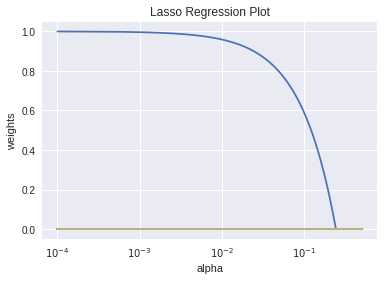

In [34]:
lasso = linear_model.Lasso(max_iter = 10000, normalize=True)
coeffs = []
for al in alphas:
    lasso.set_params(alpha=al)
    lasso.fit(np.array(x_train_sc), np.array(y_train_sc))
    coeffs.append(lasso.coef_)
ax = plt.gca()
ax.plot(2*alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title("Lasso Regression Plot")
plt.show()

In [35]:
lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(np.array(x_train_sc), np.array(y_train_sc))
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(np.array(x_train_sc), np.array(y_train_sc))
pred = lasso.predict(x_test_sc)
mean_squared_error(y_test, (pred*y_test.std())+y_test.mean())

1.2469507897880943

In [36]:
print(pd.Series(lasso.coef_, index=x_test_sc.columns))
print("Intercept: ", lasso.intercept_)
print("Aplha: ", lasso.alpha)

EchoTime           0.999
WaterTemp         -0.000
Clconcentration   -0.000
Salinity          -0.000
pH                 0.000
dtype: float64
Intercept:  -1.62364317678e-16
Aplha:  0.000121254304542


PREDICT THE MODEL

In [37]:
pred_lasso = lasso.predict(np.array(x_test_sc))
pred_lasso = (pred_lasso*y_test.std())+y_test.mean()

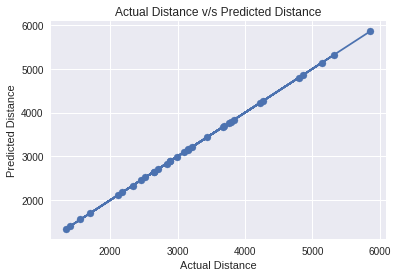

In [38]:
plt.scatter(y_test, pred_lasso)
plt.plot(y_test, y_test)
plt.xlabel("Actual Distance")
plt.ylabel("Predicted Distance")
plt.title("Actual Distance v/s Predicted Distance")
plt.show()

ERROR CALCULATION

In [39]:
errors_abs = np.abs(np.array(y_test) - pred_lasso)
errors = np.array(y_test).reshape(33,1) - pred_lasso.reshape(33,1)

In [40]:
errors.mean()

1.2677804933804455e-12

In [41]:
errors.var()

1.2469507897880945

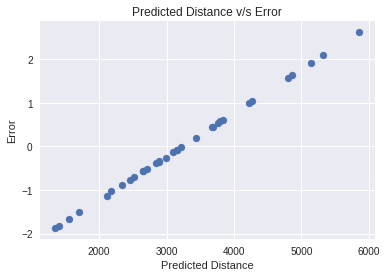

In [42]:
plt.scatter(np.array(y_test).reshape(33,1), errors)
plt.xlabel("Predicted Distance")
plt.ylabel("Error")
plt.title("Predicted Distance v/s Error")
plt.show()

HISTOGRAM OF ERRORS : LASSO

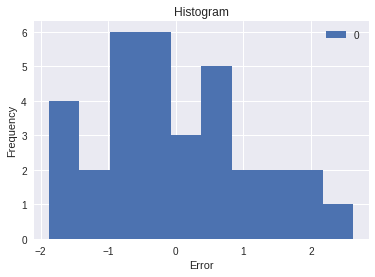

In [43]:
y = pd.DataFrame(errors)
y.plot(kind = 'hist')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

BOX PLOT

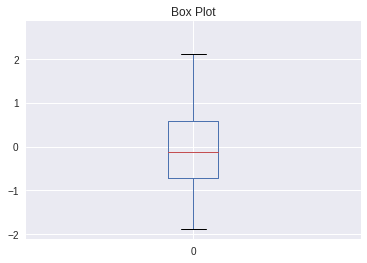

In [44]:
y.plot(kind = 'box')
plt.title("Box Plot")
plt.show()